In [1]:
# Load the necessary packages
import torch
import torchvision.transforms as transforms
import os
import sys

from speckcn2.io import prepare_data, normalize_tags, train_test_split
from speckcn2.mlmodels import get_resnet50
from speckcn2.mlops import train, score
from speckcn2.histos import tags_distribution

In [2]:
# Check if this notebook is now running in Google Colab
if 'google.colab' in sys.modules:
    # If so, I need to mout google drive to access the data and store the results
    from google.colab import drive
    drive.mount('/content/drive')
    # and change the basepath to
    basepath = 'drive/MyDrive/circuit_rbm_data/'
    print(
        '*** Running on Google Colab.\nRemember to ask colab to use the GPU by clicking on the top right corner on RAM/Disk > Change runtime type > Hardware accelerator > T4 GPU ***'
    )
else:
    basepath = '../'

In [3]:
# Set hyperparameters
final_epoch = 5
batch_size = 32
learning_rate = 0.001

In [4]:
# Set the screen parameters that will select the data to be used
nscreens = 8
original_resolution = 1024
# which correspond to the following directory
datadirectory = f'{nscreens}screens_{original_resolution}x{original_resolution}'

In [5]:
# Check if you have the data
if not os.path.isdir(datadirectory):
    # if not, download them
    try:
        !git clone 'https://github.com/MALES-project/{datadirectory}.git'
    except:
        print(
            '*** Could not download the data. Please check the repository exists and you have access to it. ***'
        )
        raise

In [6]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {device}.')

Using cpu.


In [7]:
# Define the transformation to apply to each image
transform = transforms.Compose([
    # Randomly rotate the image, since it is symmetric
    transforms.RandomRotation(degrees=(-180, 180)),
    # Take only the center of the image
    transforms.CenterCrop(410),
    # Optionally, downscale it
    transforms.Resize(256),
    transforms.ToTensor(),
])

In [8]:
# Load or preprocess the data
all_images, all_tags = prepare_data(datadirectory,
                                    transform,
                                    nimg_print=5,
                                    nreps=2)

*** Loading preprocessed data


In [9]:
# Normalize the tags between 0 and 1
dataset, normalize_tag, recover_tag = normalize_tags(all_images, all_tags)

In [10]:
# Split the data in training and testing
train_loader, test_loader = train_test_split(dataset, batch_size, 0.8)

*** There are 200 images in the dataset, 160 for training and 40 for testing.


In [11]:
# Load the model that you want to use
model, last_model_state = get_resnet50(nscreens, datadirectory)

# and set the model to run on the device
model = model.to(device)

/home/simone/.virtualenvs/MALES/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/simone/.virtualenvs/MALES/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model at epoch 5


In [12]:
# Define the loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [13]:
# Train the model...
model, average_loss = train(model, last_model_state, final_epoch, train_loader,
                            device, optimizer, criterion)
print(f'Finished Training, Loss: {average_loss:.4f}')

Finished Training, Loss: 0.0000


In [14]:
# Save the model state
torch.save(model.state_dict(),
           f'{datadirectory}/model_states/model_{final_epoch}.pth')

Loss: 0.0653


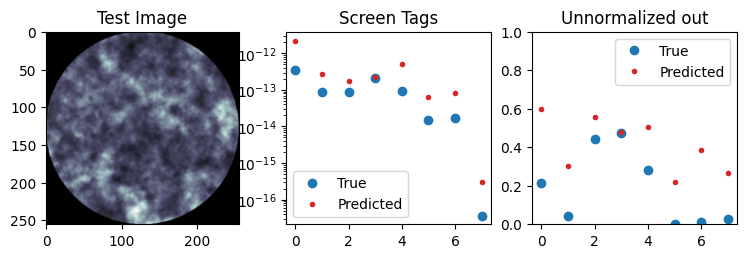

Loss: 0.0203


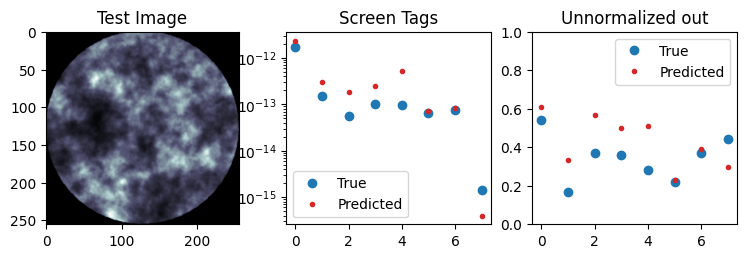

Loss: 0.1403


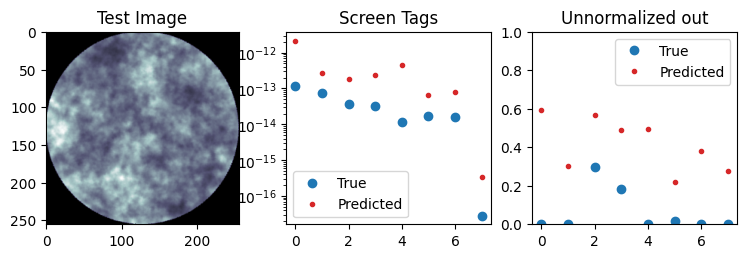

Loss: 0.0172


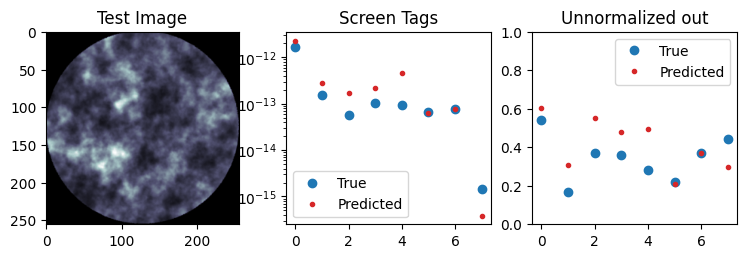

Loss: 0.0206


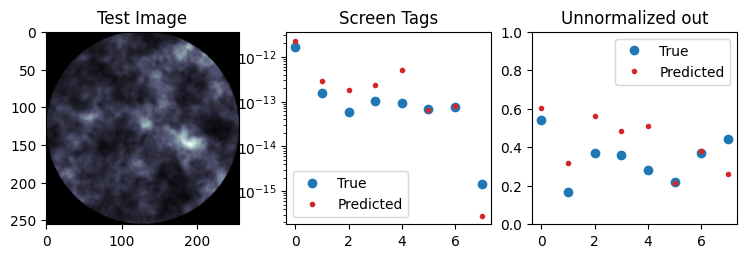

Loss: 0.1442


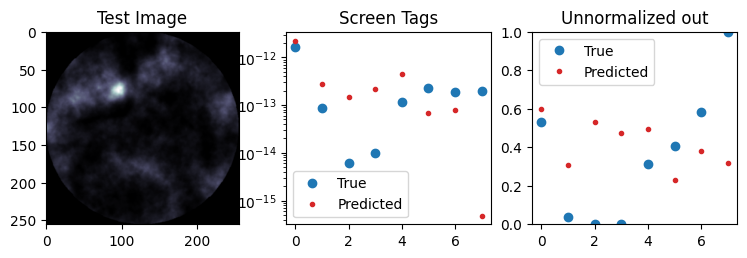

Loss: 0.0212


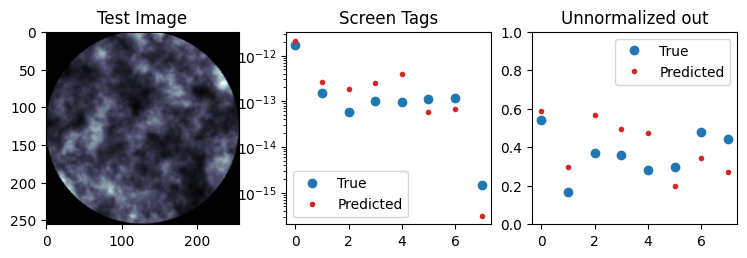

Loss: 0.0424


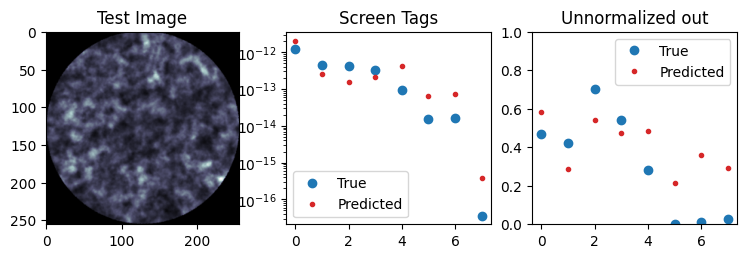

Loss: 0.0166


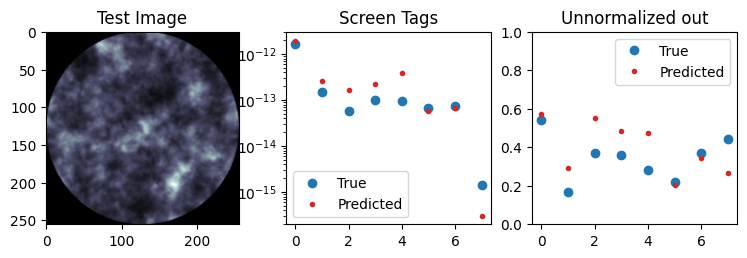

Loss: 0.1255


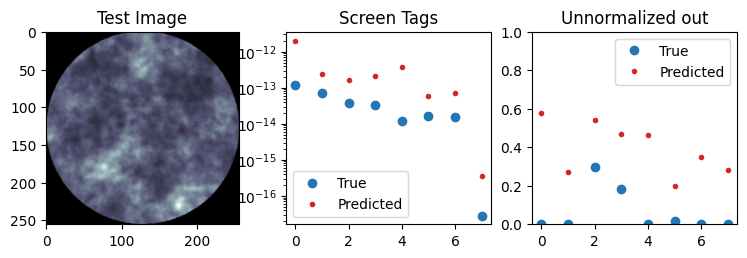

Loss: 0.2953


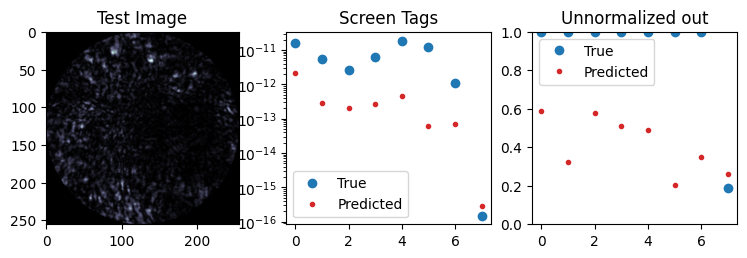

Loss: 0.0412


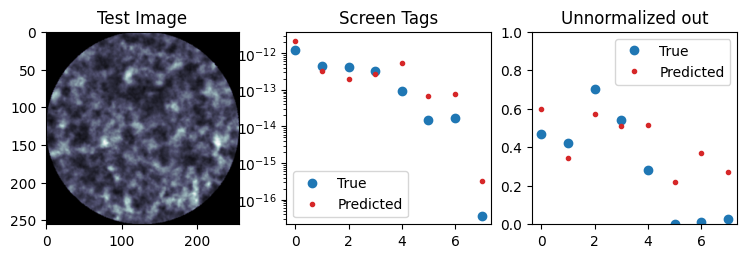

Loss: 0.0169


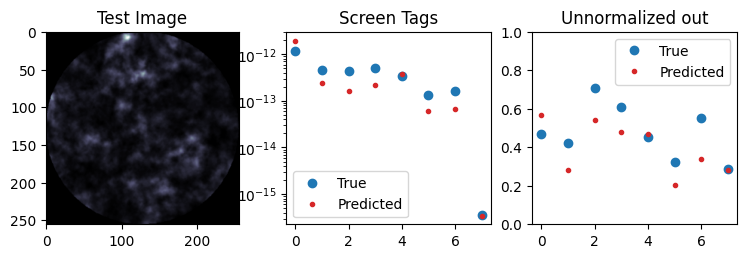

Loss: 0.0634


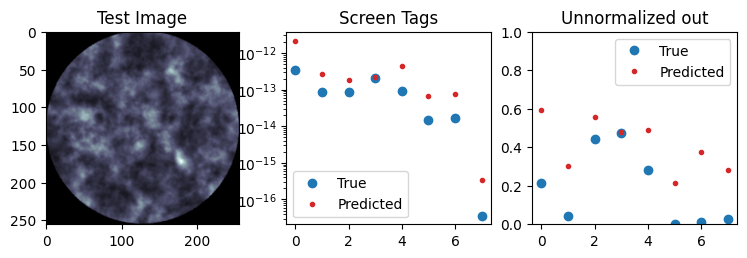

Loss: 0.3060


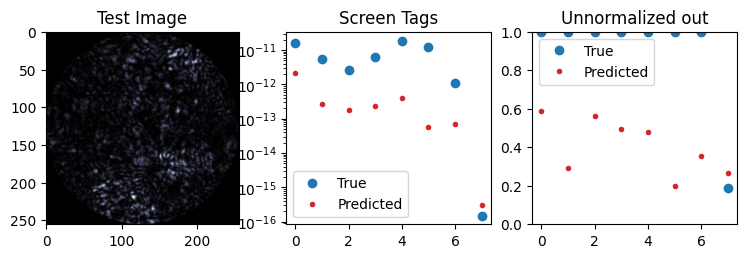

Loss: 0.0161


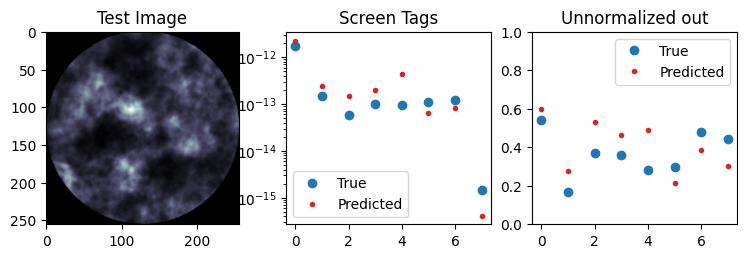

Loss: 0.0266


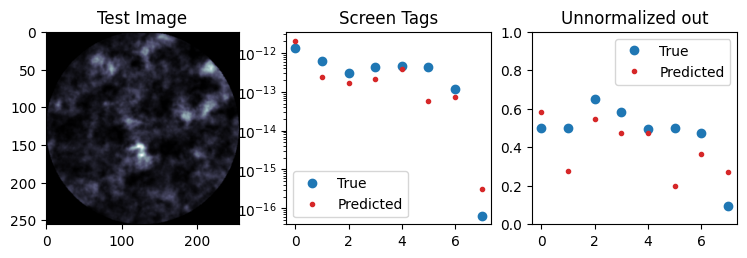

Loss: 0.0227


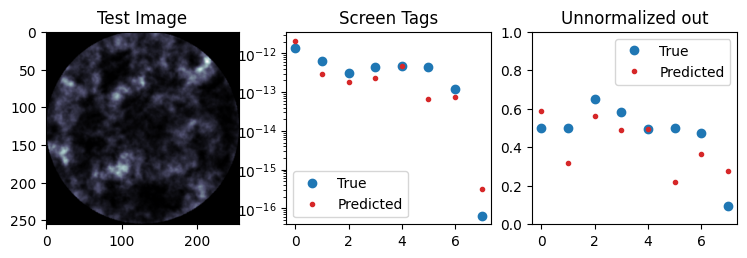

Loss: 0.0634


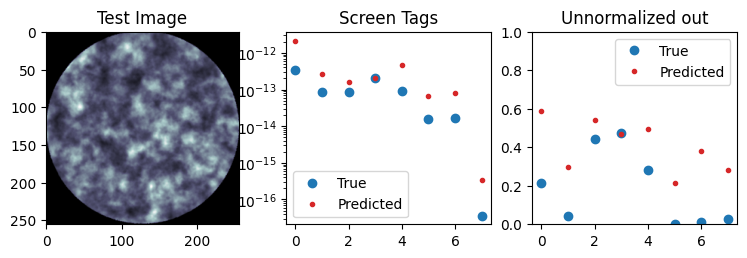

Loss: 0.0662


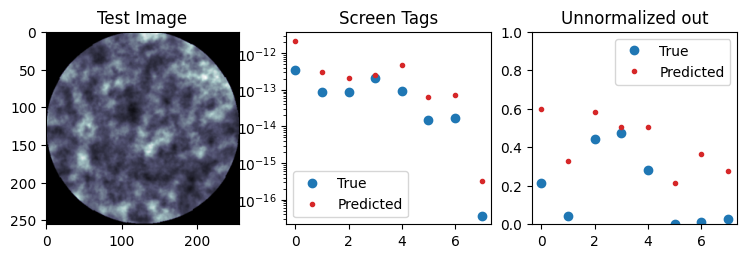

Loss: 0.0170
Loss: 0.0178
Loss: 0.0268
Loss: 0.0212
Loss: 0.2917
Loss: 0.0152
Loss: 0.0273
Loss: 0.0202
Loss: 0.0228
Loss: 0.0126
Loss: 0.1395
Loss: 0.3050
Loss: 0.0167
Loss: 0.0128
Loss: 0.1613
Loss: 0.0151
Loss: 0.0275
Loss: 0.0185
Loss: 0.0124
Loss: 0.0273


In [15]:
# Now test the model
test_tags = score(model, test_loader, device, criterion, recover_tag)

Data shape: (200, 8)
Prediction shape: (40, 8)
Train mean: 0.3823397755622864
Train std: 0.28305110335350037
Prediction mean: 0.40759706497192383
Prediction std: 0.2673680782318115


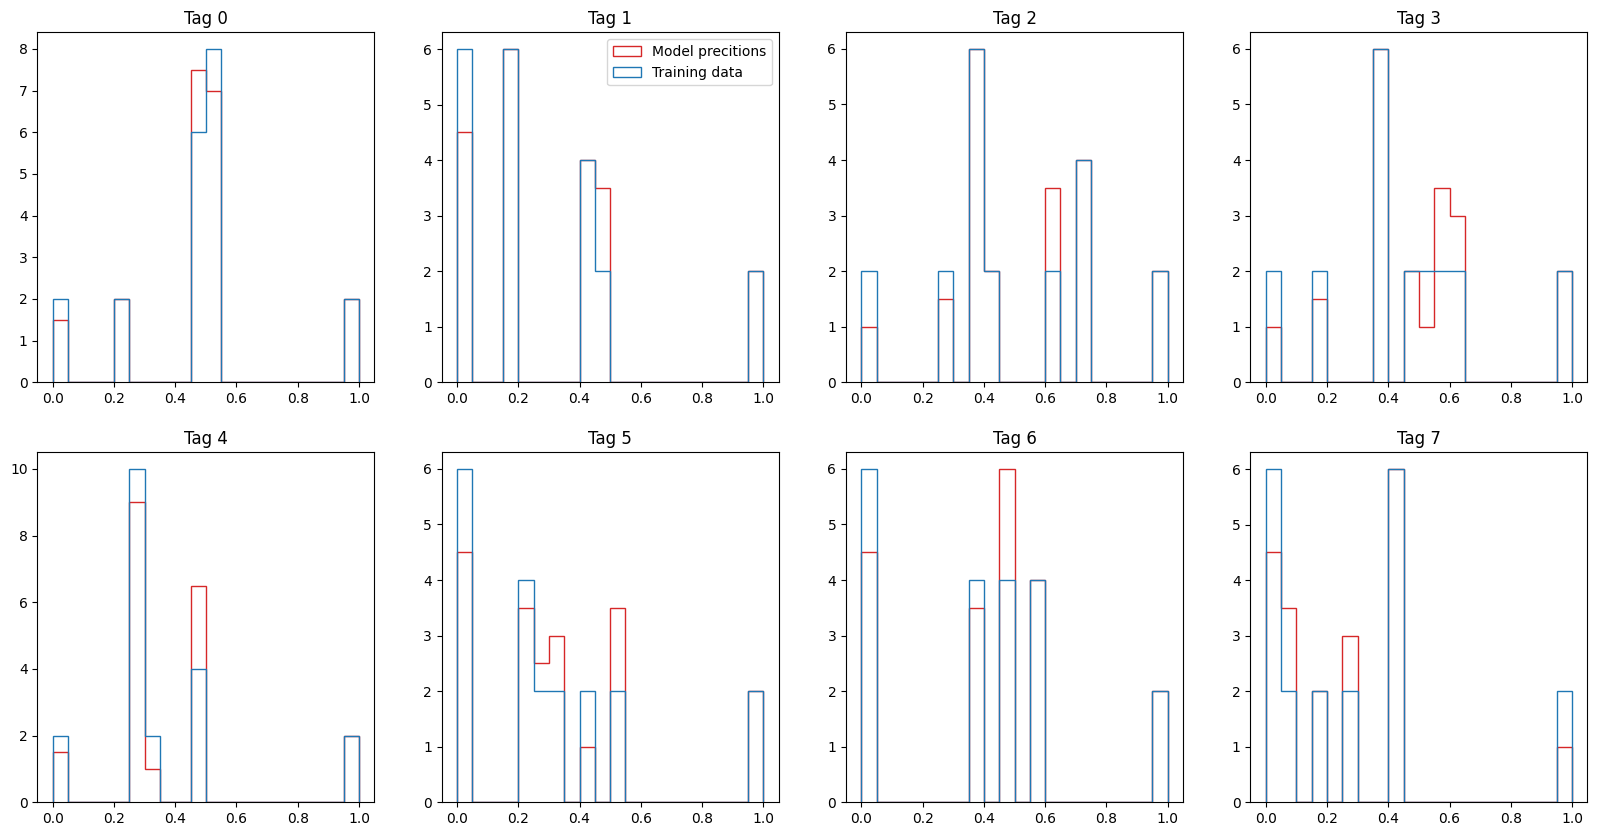

In [16]:
# Print some statistics of the screen tags
tags_distribution(dataset, test_tags, device)